In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# from ssmdm.models import DDM, LatentDDM, DDMTransitions, DDMGaussianEmissions
from ssmdm.misc import generate_clicks, factor_analysis
# from ssm.core import BaseSwitchingLDS, BaseHMM

import ssm
from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior
from ssm.util import random_rotation, ensure_args_are_lists
from ssm.observations import Observations, AutoRegressiveDiagonalNoiseObservations
from ssm.transitions import Transitions, RecurrentOnlyTransitions
from ssm.init_state_distns import InitialStateDistribution
from ssm.emissions import _LinearEmissions, GaussianEmissions, PoissonEmissions
from ssm.preprocessing import factor_analysis_with_imputation
import ssm.stats as stats

# preprocessing
# for initialization
from tqdm.auto import trange
from ssm.optimizers import adam_step, rmsprop_step, sgd_step, convex_combination
from autograd.scipy.misc import logsumexp
from autograd.tracer import getval
from autograd.misc import flatten
from autograd import value_and_grad

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

# colors = sns.xkcd_palette(color_names)

**Create model and generate data**

To do:
1) change DMGaussianEmissions to be one function that maps latents to observations. the only key difference is the initialization. have it take in the latent model ( e.g. DDM(), Accumulator2D(), as an input ! ). then use that in the initialization objective. the goal is to have this work for different models. 

In [2]:
# Transition model V2
class Accumulator2DTransitions(RecurrentOnlyTransitions):
    def __init__(self, K, D, M=0, scale=50):
        assert K == 3
        assert D == 2
#         assert M == 2
        super(Accumulator2DTransitions, self).__init__(K, D, M)
        
        self.Ws = np.zeros((K,M))
        self.Rs = np.array([[scale, 0], [0, 0], [0, scale]]).reshape((K,D)) # K by D
#         self.Rs = np.array([[scale, -scale], [0, 0], [-scale, scale]]).reshape((K,D)) # K by D
        self.r = np.array([-scale, 0, -scale])
        
    @property
    def params(self):
        return ()
    
    @params.setter
    def params(self, value):
        pass
    
    def initialize(self, datas, inputs=None, masks=None, tags=None):
        pass
    
    def m_step(self, expectations, datas, inputs, masks, tags, **kwargs):
        pass
    
# modify 2D observations to have small variance for "boundary" state. try 1e-4?
class Accumulator2DObservations(AutoRegressiveDiagonalNoiseObservations):
    def __init__(self, K, D=2, M=2, lags=1, betas=np.ones(2,), log_sigma_scale=np.log(10)*np.ones(2,), a_diag=np.ones((3,2,1))):
        assert K == 3
        assert D == 2
        assert M == 2
        super(Accumulator2DObservations, self).__init__(K, D, M)
        
        # dynamics matrix for accumulation state
        self._a_diag = a_diag
        mask = np.array([np.eye(D), np.eye(D), np.eye(D)])
        self._As = self._a_diag*mask

        # set input accumulator params, one for each dimension
        self._betas = betas
        
        # They only differ in their input 
        self.Vs[0] *= np.zeros((D,M))            # left bound
        self.Vs[1] = self._betas*np.eye(D)       # ramp
        self.Vs[2] *= np.zeros((D,M))            # right bound
        
        # set noise variances
        self.log_sigma_scale = log_sigma_scale
        self._log_sigmasq[0] = np.log(1e-4)*np.ones(D,)
        self._log_sigmasq[1] = np.log(1e-4)*np.ones(D,) + self.log_sigma_scale
        self._log_sigmasq[2] = np.log(1e-4)*np.ones(D,)
    
        # Set the remaining parameters to fixed values
        self.bs = np.zeros((3, D))
        self.mu_init = np.zeros((3, D))
        self._log_sigmasq_init = np.log(.01 * np.ones((3, D)))
        
    @property
    def params(self):
        return self._betas, self.log_sigma_scale, self._a_diag
    
#     def log_prior(self):
#         beta_mean = np.ones(self.D,)
#         beta_cov = np.eye(self.D)
#         return stats.multivariate_normal_logpdf(self._betas, beta_mean, beta_cov)
        
    @params.setter
    def params(self, value):
        self._betas, self.log_sigma_scale, self._a_diag = value
        D = self.D
        mask = np.array([np.zeros((D,D)), np.eye(D), np.zeros((D,D))])
        self.Vs = mask * self._betas
        a_mask = np.array([np.eye(D), np.eye(D), np.eye(D)])
        self._As = self._a_diag*a_mask  
        sig_mask = np.reshape(np.array([0, 1, 0]), (3, 1))
        self._log_sigmasq = np.log(1e-4)*np.ones((3,self.D)) + sig_mask * self.log_sigma_scale
        
    def initialize(self, datas, inputs=None, masks=None, tags=None):
        pass

    def m_step(self, expectations, datas, inputs, masks, tags, **kwargs):
        Observations.m_step(self, expectations, datas, inputs, masks, tags, **kwargs)
        
# def Accumulator2D(D=2, M=2, betas=np.ones(2,), log_sigma_scale=np.log(100)*np.ones(2,), a_diag=np.ones((3,2,1))):
#     K, D, M = 3, 2, 2
    
#     # Build the initial state distribution, the transitions, and the observations
#     init_state_distn = InitialStateDistribution(K, D, M)
#     init_state_distn.log_pi0 = np.log([0.01, 0.98, 0.01])
#     transition_distn = Accumulator2DTransitions(K, D, M)
#     observation_distn = Accumulator2DObservations(K, D, M, betas=betas, log_sigma_scale=log_sigma_scale, a_diag=a_diag)
    
#     return BaseHMM(K, D, M, init_state_distn, transition_distn, observation_distn)

from ssm.hmm import HMM
class Accumulator2D(HMM):
    def __init__(self, K=3, D=2, *, M=2, betas=np.ones(2,), log_sigma_scale=np.log(100)*np.ones(2,), a_diag=np.ones((3,2,1))):
    
        K, D, M = 3, 2, M

        init_state_distn = InitialStateDistribution(K, D, M=M)
        init_state_distn.log_pi0 = np.log([0.01, 0.98, 0.01])
        transition_distn = Accumulator2DTransitions(K, D, M=M)
        observation_distn = Accumulator2DObservations(K, D, M=M, betas=betas, log_sigma_scale=log_sigma_scale, a_diag=a_diag)

        super().__init__(K, D, M=M, 
                            init_state_distn=init_state_distn,
                            transitions=transition_distn, 
                            observations=observation_distn)

In [20]:
class Acc2DGaussianEmissions(GaussianEmissions):
    def __init__(self, N, K, D, M=0, single_subspace=True):
        super(Acc2DGaussianEmissions, self).__init__(N, K, D, M=M, single_subspace=single_subspace)
        # Make sure the input matrix Fs is set to zero and never updated
        self.Fs *= 0
        
    # Construct an emissions model
    @property
    def params(self):
        return self._Cs, self.ds, self.inv_etas
#         return self._Cs, self.ds

    @params.setter
    def params(self, value):
        self._Cs, self.ds, self.inv_etas = value
#         self._Cs, self.ds = value

    def initialize(self, datas, inputs=None, masks=None, tags=None, num_em_iters=50, num_tr_iters=50):

        print("Initializing...")
        print("First with FA using {} steps of EM.".format(num_em_iters))
        fa, xhats, Cov_xhats, lls = factor_analysis_with_imputation(self.D, datas, masks=masks, num_iters=num_em_iters)
        
        # define objective
        def _objective(params, itr):
            Td = sum([x.shape[0] for x in xhats])
            new_datas = [np.dot(x,params[0].T)+params[1] for x in xhats]
            obj = Accumulator2D().log_likelihood(new_datas,inputs=inputs)
            return -obj / Td
        
        # initialize R and r
        R = 0.1*np.random.randn(self.D,self.D)
        r = 0.01*np.random.randn(self.D)
        params = [R,r]
        Td = sum([x.shape[0] for x in xhats])
        
        print("Next by transforming latents to match DDM prior using {} steps of max log likelihood.".format(num_tr_iters))

        state = None
        lls = [-_objective(params, 0) * Td]
        pbar = trange(num_tr_iters)
        pbar.set_description("Epoch {} Itr {} LP: {:.1f}".format(0, 0, lls[-1]))

        for itr in pbar:
            params, val, g, state = sgd_step(value_and_grad(_objective), params, itr, state)
            lls.append(-val * Td)
            pbar.set_description("LP: {:.1f}".format(lls[-1]))
            pbar.update(1)
    
        R = params[0]
        r = params[1]
       
        # scale x1, x2 to be max at 1.1
        # TODO check and clean this
        x_transformed1 = [ (np.dot(x,R.T)+r)[:,0] for x in xhats]
        x_transformed2 = [ (np.dot(x,R.T)+r)[:,1] for x in xhats]
        max_x1 = np.max(x_transformed1)
        max_x2 = np.max(x_transformed2)
        R = (R.T*np.array([1.25 / max_x1,1.25 / max_x2])).T
        r = r * np.array([1.25 / max_x1,1.25 / max_x2])
        
        self.Cs = (fa.W @ np.linalg.inv(R)).reshape([1,self.N,self.D])
        self.ds = fa.mean - fa.W @ np.linalg.inv(R) @ r
        self.inv_etas = np.log(fa.sigmasq).reshape([1,self.N])
        
# def LatentAccumulator2D(N, betas=np.ones(2,), sigmas=1e-3 * np.ones((3, 2)), a_diag=np.ones((3,2,1))):
# def LatentAccumulator2D(N, betas=np.ones(2,), log_sigma_scale = np.log(10)*np.ones(2,), a_diag=np.ones((3,2,1))):
#     K, D, M = 3, 2, 2
    
#     # Build the initial state distribution, the transitions, and the observations
#     init_state_distn = InitialStateDistribution(K, D, M)
#     init_state_distn.log_pi0 = np.log([0.01, 0.98, 0.01])
#     transition_distn = Accumulator2DTransitions(K, D, M)
#     dynamics_distn = Accumulator2DObservations(K, D, M, betas=betas, log_sigma_scale=log_sigma_scale, a_diag=a_diag)
    
#     # add in Poisson here... 
#     emission_distn = Acc2DGaussianEmissions(N, K, D, M=M, single_subspace=True)

#     return BaseSwitchingLDS(N, K, D, M, init_state_distn, transition_distn, dynamics_distn, emission_distn)

from ssm.lds import SLDS
class LatentAccumulator2D(SLDS):
    def __init__(self, N, K=3, D=2, *, M=2, betas=np.ones(2,), log_sigma_scale = np.log(10)*np.ones(2,), a_diag=np.ones((3,2,1))):
    
        K, D, M = 3, 2, M

        init_state_distn = InitialStateDistribution(K, D, M=M)
        init_state_distn.log_pi0 = np.log([0.01, 0.98, 0.01])
        transition_distn = Accumulator2DTransitions(K, D, M)
        dynamics_distn = Accumulator2DObservations(K, D, M, betas=betas, log_sigma_scale=log_sigma_scale, a_diag=a_diag)
        emission_distn = Acc2DGaussianEmissions(N, K, D, M=M, single_subspace=True)

        super().__init__(N, K=K, D=D, M=M, 
                         init_state_distn=init_state_distn,
                         transitions=transition_distn, 
                         dynamics=dynamics_distn,
                         emissions=emission_distn)

In [4]:
# create 2D accumulator

# sigmas = np.array([[1e-4,1e-4],[5e-4,5e-4],[1e-4,1e-4]])
betas = np.array([1.0,1.0])
a_diag = np.ones((3,2,1))
# a_diag[1,:,0] = np.array([0.99,0.98])
# acc2 = Accumulator2D(sigmas=sigmas,betas=betas,a_diag=a_diag)
log_sigma_scale = np.log(10)*np.ones(2,)
acc2 = Accumulator2D(betas=betas,log_sigma_scale=log_sigma_scale,a_diag=a_diag)

# Sample state trajectories
T = 100 # number of time bins
trial_time = 1.0 # trial length in seconds
dt = 0.01 # bin size in seconds
N_samples = 40 

# input statistics
total_rate = 40 # the sum of the right and left poisson process rates is 40

us = []
zs = []
xs = []

for smpl in range(N_samples):

    # randomly draw right and left rates
    rate_r = np.random.randint(0,total_rate+1)
#     rate_r = np.random.choice(np.append(np.arange(11),np.arange(30,41,1)))
    rate_l = total_rate - rate_r

    # generate binned right and left clicks
    u_r, u_l = generate_clicks(T=trial_time,dt=dt,rate_r=rate_r,rate_l=rate_l)
    
    # input is sum of u_r and u_l
    u = 0.1*np.array([u_r,u_l]).T
    z, x = acc2.sample(T, input=u)
    
    us.append(u)
    zs.append(z)
    xs.append(x)

In [ ]:
from matplotlib import colors
cmap = colors.ListedColormap(['red', 'black', 'blue'])
bounds=[0,1,2]
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.figure()
plt.subplot(121)
plt.imshow(zs[0].reshape((1,T)),aspect="auto",cmap=cmap)
plt.clim([0,2])
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(zs[16].reshape((1,T)),aspect="auto",cmap=cmap)
plt.clim([0,2])
plt.xticks([])
plt.yticks([])
# plt.savefig("example_2d_accum_discrete.png")

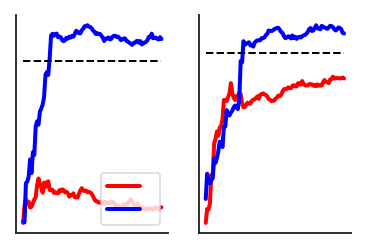

In [13]:
plt.figure()
plt.subplot(121)
# plt.plot(us[0])
plt.plot(xs[0][:,0],'r',linewidth=4)
plt.plot(xs[0][:,1],'b',linewidth=4)
plt.plot(np.ones(T),'k--',linewidth=2)
plt.xticks([])
plt.yticks([])
plt.legend(["",""],loc="lower right")
plt.subplot(122)
plt.plot(xs[16][:,0],'r',linewidth=4)
plt.plot(xs[16][:,1],'b',linewidth=4)
plt.plot(np.ones(T),'k--',linewidth=2)
plt.xticks([])
plt.yticks([])
sns.despine(right=True)
# plt.savefig("example_2d_accum_continuous.png")

In [ ]:
ys[0][0,:]

In [ ]:
prob1 = np.array([0.35,0.4,0.05,0.1,0.05,0.05])
prob2 = np.array([0.04,0.05,0.425,0.375,0.05,0.06])
prob3 = np.array([0.02,0.03,0.1,0.05,0.2,0.6])
probs = [prob1,prob2,prob3]
y_cat = [np.random.multinomial(1,probs[z]) for z in zs[0]]
y_prob = [probs[z] for z in zs[0]]
y_cat2 = [np.random.multinomial(1,probs[z]) for z in zs[16]]
# print(np.sum(prob3))
y_prob2 = [probs[z] for z in zs[16]]

# C_cat = np.random.randn(6,2)
# y_cat = np.exp(np.dot(xs[0], C_cat.T))
# y_cat_norm = y_cat / np.sum(y_cat,axis=1).reshape((T,1))
# y_cat[0,:]
plt.figure()
plt.subplot(121)
plt.imshow(np.array(y_cat).T,aspect="auto")
# plt.clim([0,0.5])
# plt.colorbar()
plt.xticks([])
plt.yticks([])
sns.despine(right=True)
plt.subplot(122)
plt.imshow(np.array(y_cat2).T,aspect="auto")
# plt.clim([0,0.5])
# plt.colorbar()
plt.xticks([])
plt.yticks([])
sns.despine(right=True)
plt.savefig("mult_observations.png")

plt.figure()
plt.subplot(121)
plt.imshow(np.array(y_prob).T,aspect="auto",cmap="hot")
plt.clim([0,0.7])
# plt.colorbar()
plt.xticks([])
plt.yticks([])
sns.despine(right=True)
plt.subplot(122)
plt.imshow(np.array(y_prob2).T,aspect="auto",cmap="hot")
plt.clim([0,0.7])
plt.xticks([])
plt.yticks([])
sns.despine(right=True)
plt.savefig("multinomial_probabilities.png")
plt.figure()
plt.imshow(np.array(y_prob2).T,aspect="auto",cmap="hot")
plt.clim([0,0.7])
plt.colorbar()
# plt.savefig("mult_colorbar.png")


In [ ]:
print(np.shape(y_cat))
print(np.shape(np.sum(y_cat,axis=1)))
print(np.shape(y_cat / np.sum(y_cat,axis=1).reshape((T,1))))
y_cat_norm = y_cat / np.sum(y_cat,axis=1).reshape((T,1))
print(y_cat_norm[1,:])

In [ ]:
# tr = 0
tr+=1
plt.figure()
plt.plot(xs[tr][:,0],'r')
plt.plot(xs[tr][:,1],'b')
plt.plot(zs[tr],'k')

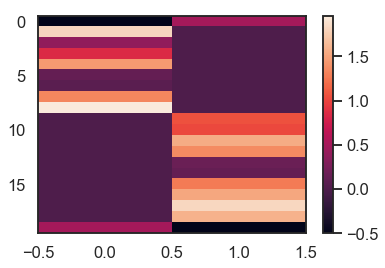

In [5]:
# generate C
N = 20
D = 2

# random
C = np.random.randn(N, D)

# structured
choice = np.random.choice(2, size=N)
choice = np.array(sorted(choice))
C = np.random.rand(N, D) * (np.arange(D)[None, :] == choice[:, None]) * 2
C[0,:] = np.array([-0.5,0.5])
C[-1,:] = np.array([0.5,-0.5])

plt.imshow(C,aspect="auto")
plt.colorbar()

In [6]:
# generate data
# N = 10
# D = 2
ys = [np.dot(x, C.T) + 1.0 + .1 * np.random.randn(T, N) for x in xs]

**Initialize model**

In [7]:
latent_acc = LatentAccumulator2D(N)

In [8]:
latent_acc.initialize(ys, inputs=us,num_em_iters=25)

Initializing...
First with FA using 50 steps of EM.


/Users/davidzoltowski/github/pybasicbayes/pybasicbayes/util/stats.py:184: RuntimeWarning: divide by zero encountered in true_divide
  return 1./np.random.gamma(alpha, 1./beta)



Next by transforming latents to match DDM prior using 50 steps of max log likelihood.



Initializing with an ARHMM using 25 steps of EM.


In [22]:
latent_acc.emissions.inv_etas

array([[-4.5949074 , -4.60907372, -4.62198044, -4.58028438, -4.63593084,
        -4.65698647, -4.60382956, -4.57755497, -4.6256046 , -4.57797119,
        -4.57156997, -4.61347674, -4.6304392 , -4.59024223, -4.56689815,
        -4.60140071, -4.60785031, -4.58649246, -4.60919343, -4.60582956]])

**Look at initialization results!**

([<matplotlib.axis.XTick at 0x10a095da0>,
 <a list of 2 Text xticklabel objects>)

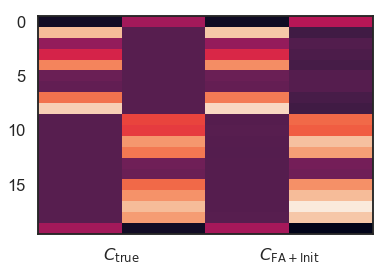

In [10]:
plt.figure()
plt.imshow(np.concatenate((C,latent_acc.emissions.Cs[0,:,:]),axis=1),aspect='auto')
plt.xticks([0.5, 2.5], ["$C_{\\mathrm{true}}$", "$C_{\\mathrm{FA+Init}}$"])

**Initialize variational posterior**

In [23]:
# Create a variational posterior
from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior, \
    SLDSStructuredMeanFieldVariationalPosterior
# q = SLDSMeanFieldVariationalPosterior(latent_acc, ys, inputs=us,initial_variance=0.001)
# q_mf = SLDSMeanFieldVariationalPosterior(latent_acc, y_masked, inputs=us,  masks=masks)
# q = SLDSTriDiagVariationalPosterior(latent_acc, ys, inputs=us)
q_laplace_em = SLDSStructuredMeanFieldVariationalPosterior(latent_acc, ys, inputs=us)

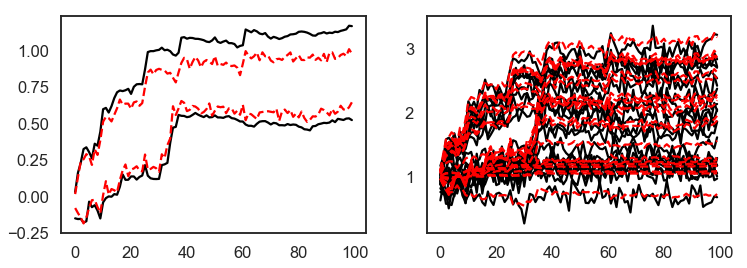

In [24]:
tr = 0
# tr += 1
q_x = q_laplace_em.mean_continuous_states[tr]
yhat = latent_acc.smooth(q_x, ys[tr], input=us[tr])
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(xs[tr],'k')
plt.plot(q_x,'r--')
plt.subplot(1,2,2)
plt.plot(ys[tr],'k')
plt.plot(yhat, 'r--')


**Fit model**

In [25]:
for tr in range(N_samples):
    q_laplace_em._params[tr]["h"] *= 100
    q_laplace_em._params[tr]["J_diag"] *= 100

In [45]:
# latent_acc.elbo(q, ys, inputs=us)

In [ ]:
# what parameters does it have? 
# latent_acc.init_state_distn.log_pi0 # initial state distribution
# latent_acc.dynamics._betas # mapping from input to latents
# latent_acc.dynamics._log_sigmasq # dynamics (diagonal) covariance
# latent_acc.dynamics._As # dynamics
# latent_acc.emissions.Cs # emissions matrix
# latent_acc.emissions.ds # emissions mean
# latent_acc.emissions.inv_etas # emissions log variance?

In [48]:
print(acc2.observations.params)
print(latent_acc.dynamics.params)

(array([1., 1.]), array([2.30258509, 2.30258509]), array([[[1.],
        [1.]],

       [[1.],
        [1.]],

       [[1.],
        [1.]]]))
(array([0.9032787 , 0.84037178]), array([2.16670372, 2.08888468]), array([[[1.00019089],
        [1.00056954]],

       [[0.9992804 ],
        [0.99517886]],

       [[0.99748409],
        [0.99971684]]]))


In [74]:
# elbos = latent_acc.fit(q, ys, inputs=us, method="svi", num_iters=1000, initialize=False)

# # Get the posterior mean of the continuous states
# q_x = q.mean[0]

elbos = latent_acc.fit(q_laplace_em, ys, inputs=us, num_iters=25, method="laplace_em", initialize=False, 
                       num_samples=1, alpha=0.5, maxiter=25, num_optimizer_iters=25)

In [75]:
latent_acc.dynamics.mu_init
# latent_acc.dynamics._betas = np.ones(2,)
dir(latent_acc.init_state_distn)
latent_acc.dynamics.params

(array([0.96109339, 0.93756498]),
 array([2.38427427, 2.18474951]),
 array([[[1.00031087],
         [1.0010399 ]],
 
        [[0.99888855],
         [0.99731871]],
 
        [[0.99999251],
         [0.99992685]]]))

In [131]:
# latent_acc.dynamics._betas = np.ones(2,)
# latent_acc.dynamics.log_sigma_scale = np.log(10)*np.ones(2,)
# latent_acc.dynamics.As = acc2.observations.As
# latent_acc.dynamics._log_sigmasq = acc2.observations._log_sigmasq
# latent_acc.emissions.Cs = C.reshape((1,N,D))
# latent_acc.emissions.ds = np.ones(N)
# latent_acc.emissions.inv_etas = np.log(1e-2)*np.ones(N)

Text(0,0.5,'ELBO')

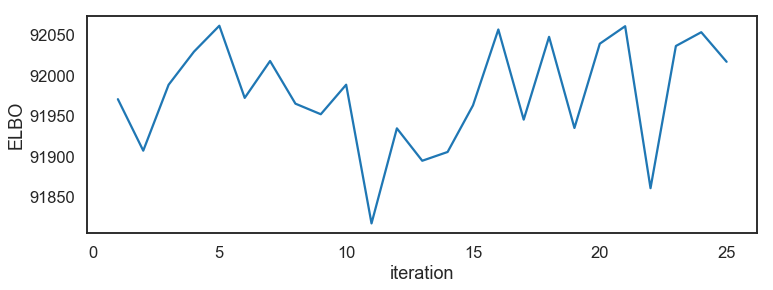

In [76]:
plt.figure(figsize=[12,4])
# plt.subplot(1,2,1)
plt.plot(elbos)
plt.xlabel('iteration')
plt.ylabel('ELBO')
# plt.subplot(1,2,2)
# plt.plot(elbos[-100:])
# plt.xlabel('last 100 iters')
# plt.ylabel('ELBO')
# plt.tight_layout()

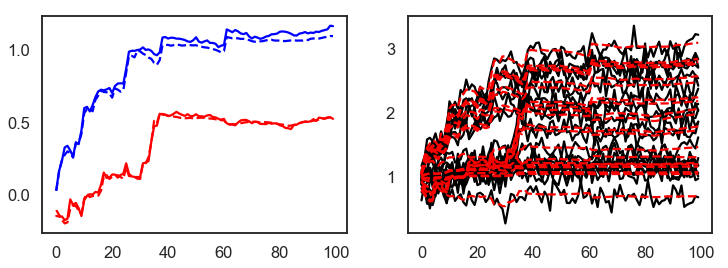

In [77]:
tr = 0
# tr += 1 
q_x = q_laplace_em.mean_continuous_states[tr]
yhat = latent_acc.smooth(q_x, ys[tr], input=us[tr])
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(xs[tr][:,0],'r')
plt.plot(xs[tr][:,1],'b')
plt.plot(q_x[:,0],'r--')
plt.plot(q_x[:,1],'b--')
plt.subplot(1,2,2)
plt.plot(ys[tr],'k')
plt.plot(yhat, 'r--')

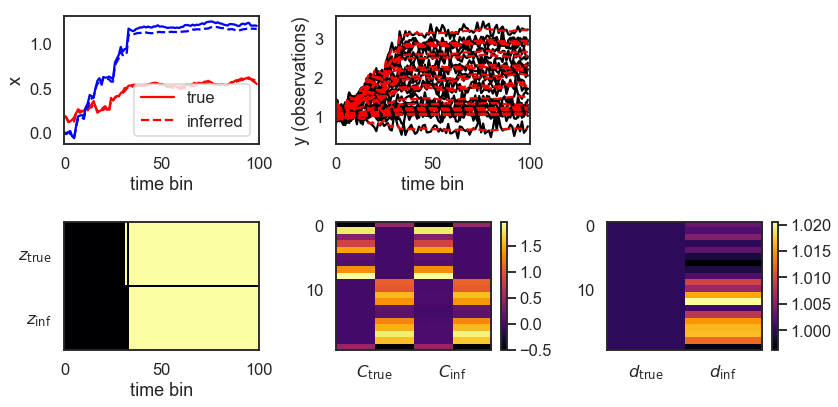

In [81]:
# tr = 0
tr += 1 

xlim = (0, np.shape(xs[tr])[0])

q_x = q_laplace_em.mean_continuous_states[tr]

yhat = latent_acc.smooth(q_x, ys[tr], input=us[tr])
plt.figure(figsize=[12,6])
plt.subplot(231)
# plt.plot(xs[tr],'k')
# plt.plot(q_mf.mean[tr],'r--')
plt.plot(xs[tr][:,0],'r')
plt.plot(q_x[:,0],'r--')
plt.plot(xs[tr][:,1],'b')
plt.plot(q_x[:,1],'b--')
plt.xlim(xlim)
plt.xlabel('time bin')
plt.ylabel('x')
plt.legend(['true','inferred'])

plt.subplot(232)
plt.plot(ys[tr],'k')
plt.plot(yhat, 'r--')
# plt.imshow(ys[tr].T,aspect='auto', cmap="inferno")
plt.xlim(xlim)
plt.xlabel('time bin')
plt.ylabel('y (observations)')
# plt.plot(np.dot(q_mf.mean[tr],latent_ddm.emissions.Cs[0,:,:].T)+latent_ddm.emissions.ds,'b--')

# plt.subplot(233)
# # plt.plot(ys[tr],'k')
# # plt.plot(yhat, 'r--')
# plt.imshow(yhat.T,aspect='auto', cmap="inferno")
# plt.xlim(xlim)
# plt.xlabel('time bin')
# plt.ylabel('y (observations)')

zhat = latent_acc.most_likely_states(q_x, ys[tr], input=us[tr])
plt.subplot(234)
plt.imshow(np.row_stack((zs[tr], zhat)), aspect="auto", cmap="inferno")
plt.plot(xlim, [0.5, 0.5], '-k', lw=2)
plt.xlim(xlim)
plt.yticks([0, 1], ["$z_{\\mathrm{true}}$", "$z_{\\mathrm{inf}}$"])
plt.xlabel('time bin')

plt.subplot(235)
plt.imshow(np.concatenate((C,latent_acc.emissions.Cs[0,:,:]),axis=1),aspect='auto', cmap="inferno")
plt.xticks([0.5, 2.5], ["$C_{\\mathrm{true}}$", "$C_{\\mathrm{inf}}$"])
# plt.clim([-2.5,2.5])
plt.colorbar()

d = np.ones(N)
plt.subplot(236)
plt.imshow(np.concatenate((d.reshape(N,1),latent_acc.emissions.ds.reshape((N,1))),axis=1),aspect='auto', cmap="inferno")
plt.xticks([0, 1], ["$d_{\\mathrm{true}}$", "$d_{\\mathrm{inf}}$"])
# plt.clim([0.5,1.5])
plt.colorbar()
plt.tight_layout()

# plt.savefig('2d_example_2.png')

In [ ]:
x0 = np.mean(xs[0] - q.mean[0])*np.ones((2,1))
print("d-hat: ", C@x0 + 1.0)
print("d-inferred: ", latent_acc.emissions.ds)

In [ ]:
plt.figure()
plt.subplot(1,3,1)
plt.imshow(C,aspect='auto')
plt.clim([-2.5,2.5])
plt.title('True C')
plt.subplot(1,3,2)
plt.imshow(latent_acc.emissions.Cs[0,:,:],aspect='auto')
plt.clim([-2.5,2.5])
plt.title('Inferred')
plt.subplot(1,3,3)
plt.imshow(C-latent_acc.emissions.Cs[0,:,:],aspect='auto')
plt.clim([-2.5,2.5])
plt.title("Difference")
plt.tight_layout()

**Compare fit params**

In [132]:
print("Dynamics: ", acc2.observations.As)
print("Beta: ", acc2.observations._betas)
print("Sigma: ", acc2.observations._log_sigmasq)
print("Obs noise: ", np.log(1e-2))

Dynamics:  [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
Beta:  [1. 1.]
Sigma:  [[-9.21034037 -9.21034037]
 [-6.90775528 -6.90775528]
 [-9.21034037 -9.21034037]]
Obs noise:  -4.605170185988091


In [133]:
print("Dynamics: ", latent_acc.dynamics.As)
print("Beta: ", latent_acc.dynamics._betas)
print("Sigma: ", latent_acc.dynamics._log_sigmasq)
print("Obs noise: ", latent_acc.emissions.inv_etas)

Dynamics:  [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
Beta:  [1. 1.]
Sigma:  [[-9.21034037 -9.21034037]
 [-6.90775528 -6.90775528]
 [-9.21034037 -9.21034037]]
Obs noise:  [-4.60517019 -4.60517019 -4.60517019 -4.60517019 -4.60517019 -4.60517019
 -4.60517019 -4.60517019 -4.60517019 -4.60517019 -4.60517019 -4.60517019
 -4.60517019 -4.60517019 -4.60517019 -4.60517019 -4.60517019 -4.60517019
 -4.60517019 -4.60517019]


In [129]:
print("ds: ",latent_acc.emissions.ds)

ds:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


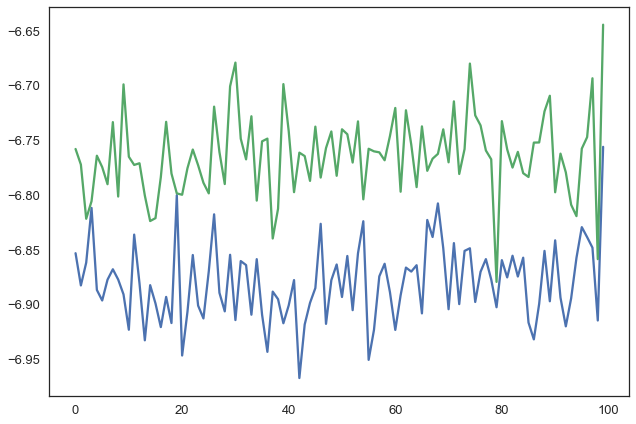

In [122]:
plt.figure()
plt.plot(q.params[1][1])
# q.params[1][1]

In [ ]:
# np.savez('latent_acc_svi_tridiag',latent_acc=latent_acc,ys=ys,xs=xs,us=us,zs=zs,q=q,true_acc=acc)